In [ ]:
# Notebook 4: Model Evaluation 
# Objective: Thoroughly evaluate the best model and analyze its decisions

C:\Users\user\anaconda3\envs\ml_stable\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


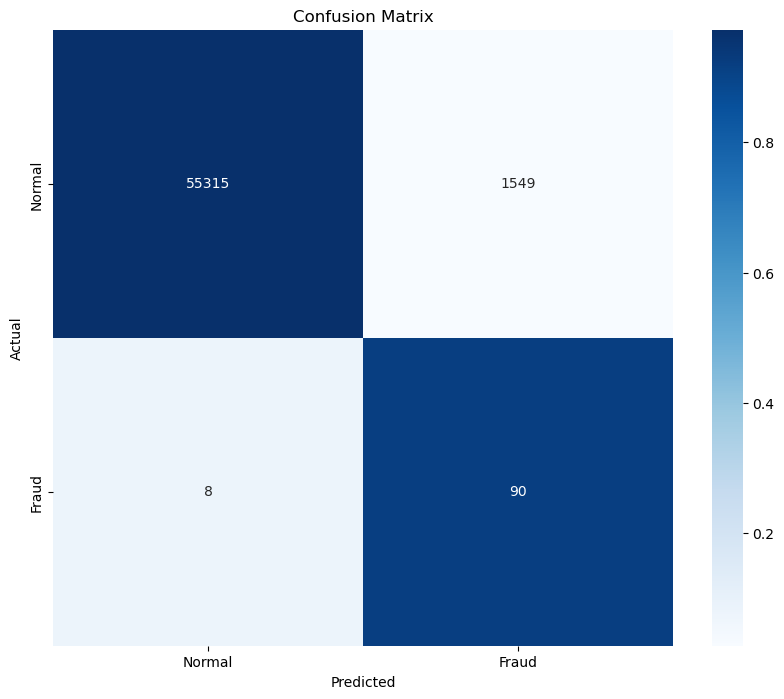

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import confusion_matrix, classification_report
import shap

# Define absolute paths
data_dir = r'C:\Users\user\Desktop\fraud_detection_project\data'
models_dir = r'C:\Users\user\Desktop\fraud_detection_project\models'
viz_dir = r'C:\Users\user\Desktop\fraud_detection_project\visualizations\results'

# Create directories if they don't exist
os.makedirs(viz_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Load data and best model
with open(os.path.join(data_dir, 'processed', 'prepared_data.pkl'), 'rb') as f:
    data = pickle.load(f)

X_test, y_test = data['X_test'], data['y_test']

with open(os.path.join(models_dir, 'fraud_detection_model.pkl'), 'rb') as f:
    best_model = pickle.load(f)

print("Model loaded:", best_model)

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion matrix with normalized values
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(viz_dir, 'confusion_matrix.png'))
plt.show()

In [9]:
# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Analysis of false positives and false negatives
df_processed = pd.read_csv(os.path.join(data_dir, 'processed', 'creditcard_processed.csv'))

# Recreate test set index
X_test_idx = X_test.index
test_df = df_processed.iloc[X_test_idx].copy()
test_df['predicted'] = y_pred
test_df['probability'] = y_proba

# False positives (predicted as fraud but actually normal)
false_positives = test_df[(test_df['Class'] == 0) & (test_df['predicted'] == 1)]
# False negatives (predicted as normal but actually fraud)
false_negatives = test_df[(test_df['Class'] == 1) & (test_df['predicted'] == 0)]

print(f"Number of false positives: {len(false_positives)}")
print(f"Number of false negatives: {len(false_negatives)}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Number of false positives: 1549
Number of false negatives: 8


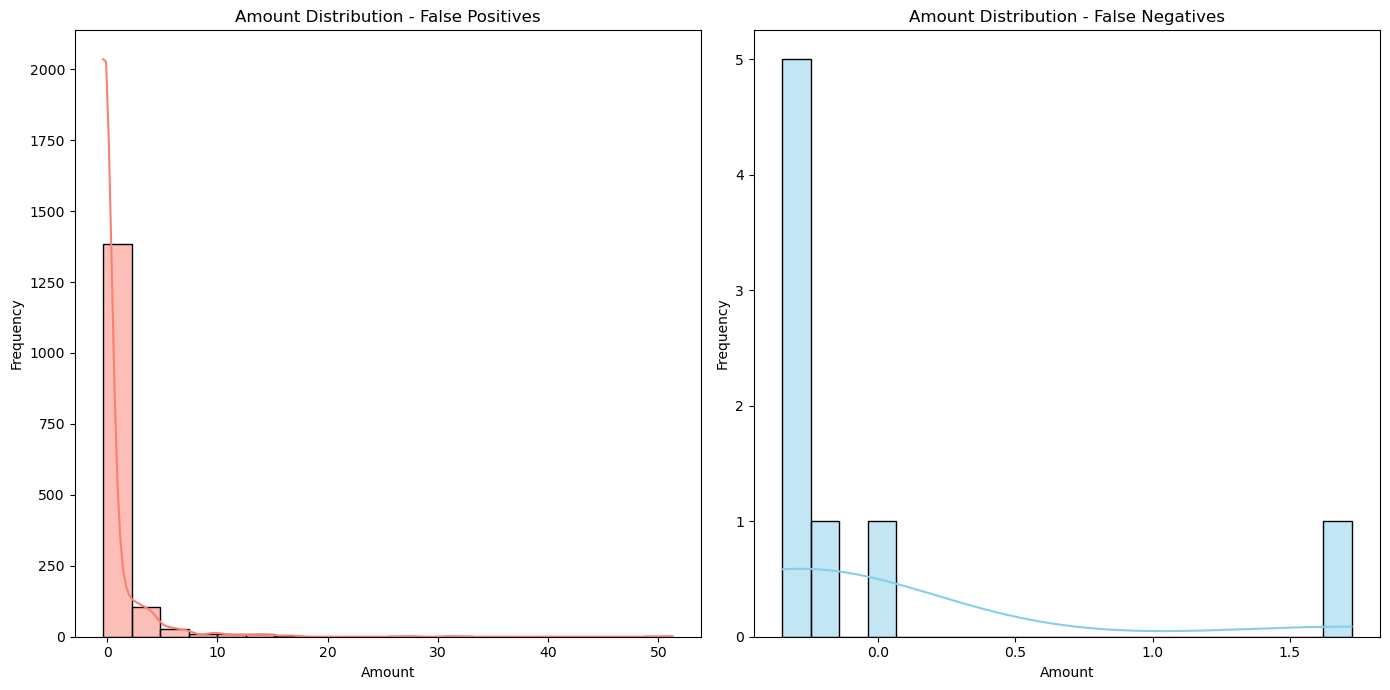

In [10]:
# Analysis of false positives vs false negatives
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('Amount Distribution - False Positives')
sns.histplot(false_positives['Amount'], bins=20, kde=True, color='salmon')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title('Amount Distribution - False Negatives')
sns.histplot(false_negatives['Amount'], bins=20, kde=True, color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'false_predictions_amount.png'))
plt.show()

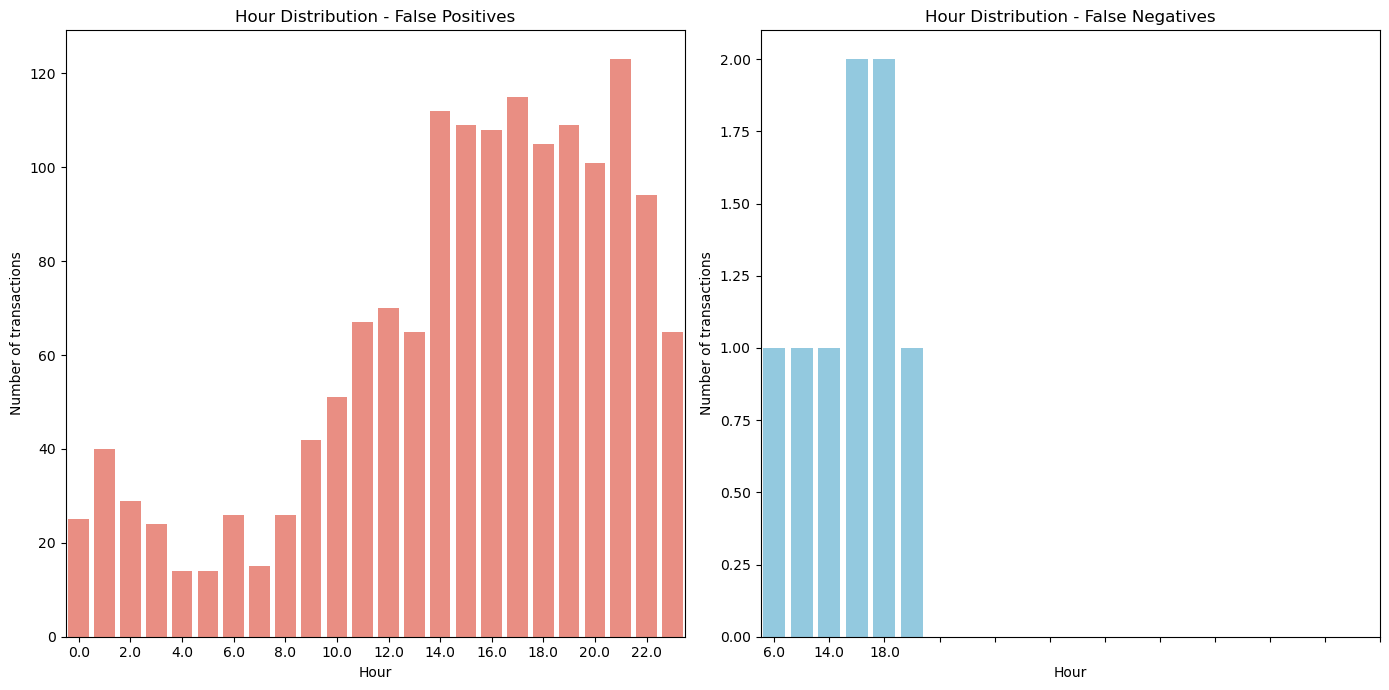

In [13]:
# Analysis of hour for false positives and false negatives
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('Hour Distribution - False Positives')
sns.countplot(x='Hour', data=false_positives, color='salmon')
plt.xlabel('Hour')
plt.ylabel('Number of transactions')
plt.xticks(range(0, 24, 2))

plt.subplot(1, 2, 2)
plt.title('Hour Distribution - False Negatives')
sns.countplot(x='Hour', data=false_negatives, color='skyblue')
plt.xlabel('Hour')
plt.ylabel('Number of transactions')
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'false_predictions_hour.png'))
plt.show()

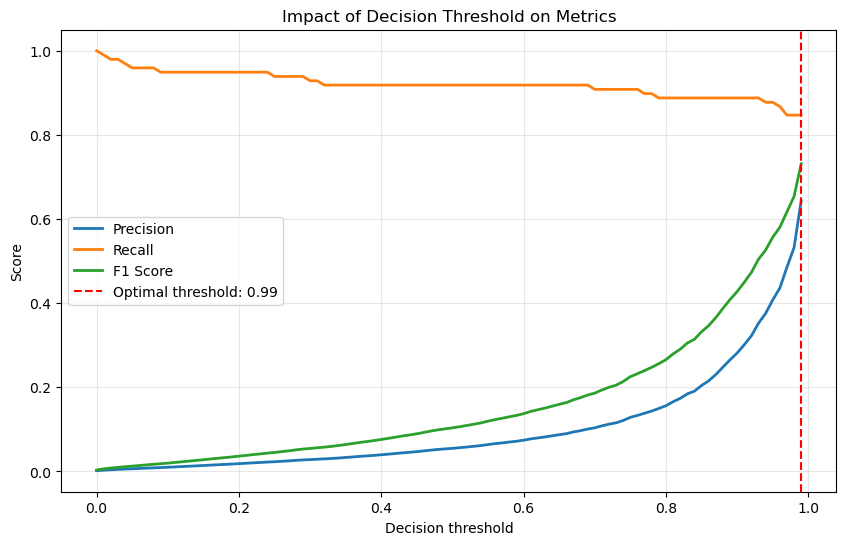

Optimal threshold for F1-Score: 0.99
F1-Score at optimal threshold: 0.7313
Precision at optimal threshold: 0.6434
Recall at optimal threshold: 0.8469


In [15]:
# Optimal threshold curve
from sklearn.metrics import precision_recall_curve

thresholds = np.arange(0, 1, 0.01)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_t = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the best threshold for F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.axvline(x=best_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold: {best_threshold:.2f}')
plt.xlabel('Decision threshold')
plt.ylabel('Score')
plt.title('Impact of Decision Threshold on Metrics')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(os.path.join(viz_dir, 'threshold_optimization.png'))
plt.show()

print(f"Optimal threshold for F1-Score: {best_threshold:.2f}")
print(f"F1-Score at optimal threshold: {f1_scores[best_threshold_idx]:.4f}")
print(f"Precision at optimal threshold: {precisions[best_threshold_idx]:.4f}")
print(f"Recall at optimal threshold: {recalls[best_threshold_idx]:.4f}")


Classification report with optimal threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.85      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



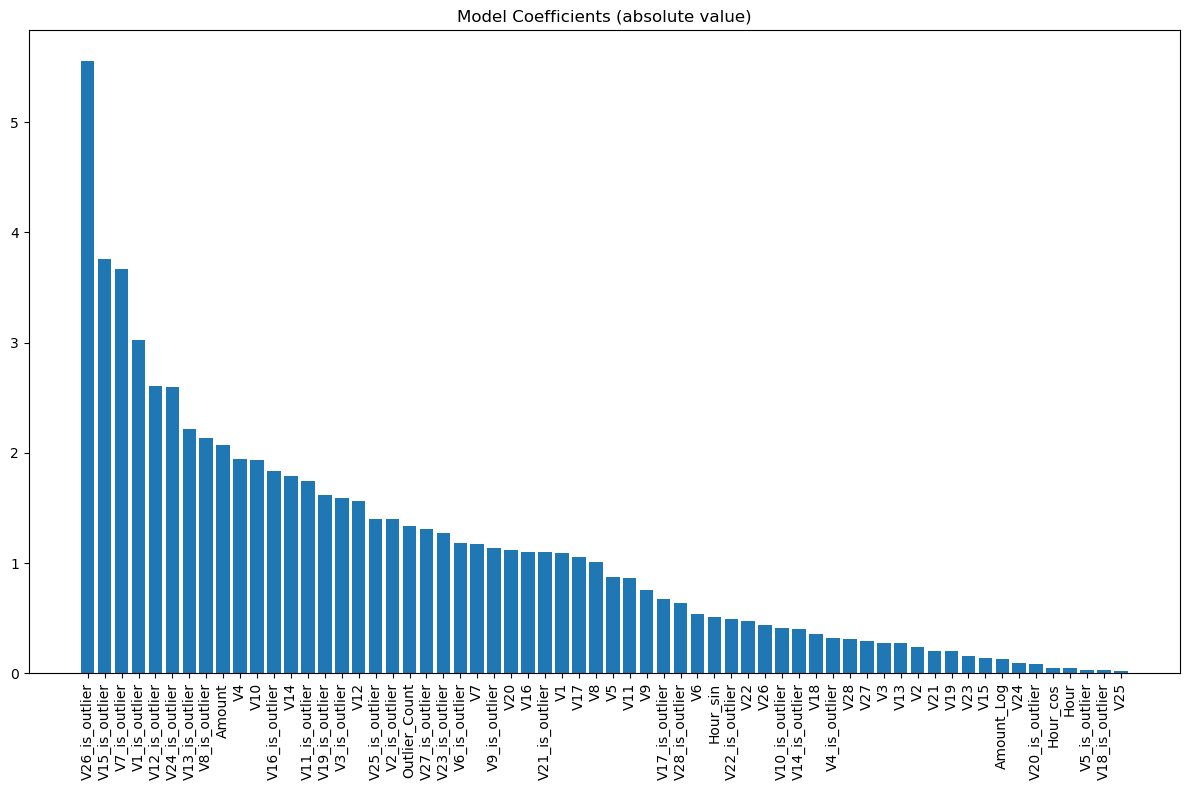


Top 10 most important features:
V26_is_outlier: 5.5558
V15_is_outlier: -3.7625
V7_is_outlier: 3.6693
V1_is_outlier: -3.0248
V12_is_outlier: 2.6059
V24_is_outlier: -2.5980
V13_is_outlier: -2.2145
V8_is_outlier: -2.1313
Amount: 2.0720
V4: 1.9443
Basic SHAP analysis completed and saved.


In [43]:
# Recalculate predictions with optimal threshold
y_pred_optimal = (y_proba >= best_threshold).astype(int)
print("\nClassification report with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X_test.columns
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance')
    plt.bar(range(X_test.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_test.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'feature_importance.png'))
    plt.show()

# Top 10 most important features
    print("\nTop 10 most important features:")
    for i in range(10):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    # For linear models
    if hasattr(best_model, 'coef_'):
        coefficients = best_model.coef_[0]
        feature_names = X_test.columns
        
        # Sort by absolute coefficient value
        indices = np.argsort(np.abs(coefficients))[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Model Coefficients (absolute value)')
        plt.bar(range(X_test.shape[1]), np.abs(coefficients[indices]), align='center')
        plt.xticks(range(X_test.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'coefficients_importance.png'))
        plt.show()

 # Top 10 most important features
    print("\nTop 10 most important features:")
    for i in range(10):
        print(f"{feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")

# SHAP Analysis (SHapley Additive exPlanations)
if hasattr(best_model, 'predict_proba'):
    try:
        # Reduced sample for SHAP analysis
        X_sample = X_test.sample(n=100, random_state=42)
        
        #  Simplified version that works for most models
        feature_names = X_sample.columns
        explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
        
        # Single SHAP plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, 
                          feature_names=feature_names)
        plt.savefig(os.path.join(viz_dir, 'shap_summary.png'))
        plt.close()
        
        print("Basic SHAP analysis completed and saved.")
    except Exception as e:
        print(f"Error during SHAP analysis: {e}")
        print("SHAP analysis skipped - this is an advanced technique we're still learning.")

In [34]:
# Business impact calculation
# Let's simulate an average cost per fraud and a cost of false positives
avg_fraud_amount = df_processed[df_processed['Class'] == 1]['Amount'].mean()
cost_per_false_positive = 50  # Estimated cost of manual review for a false positive

# Confusion matrix with optimal threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

# Calculate savings
fraud_savings = tp * avg_fraud_amount  # Detected and prevented frauds
false_positive_cost = fp * cost_per_false_positive
false_negative_cost = fn * avg_fraud_amount  # Undetected frauds

net_savings = fraud_savings - false_positive_cost - false_negative_cost

# Extrapolation to bank scale
# Let's assume our test set represents 1 month of data
annual_savings = net_savings * 12

print("\nEstimated business impact:")
print(f"Average cost per fraud: ${avg_fraud_amount:.2f}")
print(f"Gross savings (prevented frauds): ${fraud_savings:.2f}")
print(f"False positive cost: ${false_positive_cost:.2f}")
print(f"False negative cost: ${false_negative_cost:.2f}")
print(f"Net savings on the sample: ${net_savings:.2f}")
print(f"Estimated annual net savings: ${annual_savings:.2f}")


Estimated business impact:
Average cost per fraud: $0.14
Gross savings (prevented frauds): $11.24
False positive cost: $2300.00
False negative cost: $2.03
Net savings on the sample: $-2290.79
Estimated annual net savings: $-27489.53
